
# 跨模态投影层与融合算法
实现多模态特征对齐与融合的核心组件

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

## 1. 基础投影层设计
支持模态特异性特征对齐

In [2]:
class ModalityProjector(nn.Module):
    def __init__(self, in_dim, out_dim, num_layers=2):
        super().__init__()
        layers = []
        for _ in range(num_layers-1):
            layers.extend([
                nn.Linear(in_dim, in_dim//2),
                nn.GELU(),
                nn.LayerNorm(in_dim//2)
            ])
            in_dim = in_dim//2
        layers.append(nn.Linear(in_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return F.normalize(self.net(x), p=2, dim=-1)  # L2归一化

## 2. 跨模态融合层
实现多种融合策略

In [3]:
class CrossModalFusion(nn.Module):
    def __init__(self, mode='concat', hidden_dim=512):
        super().__init__()
        self.mode = mode

        if mode == 'attention':
            self.query = nn.Linear(hidden_dim, hidden_dim)
            self.key = nn.Linear(hidden_dim, hidden_dim)
            self.value = nn.Linear(hidden_dim, hidden_dim)
            self.attn = nn.MultiheadAttention(hidden_dim, 8)
        elif mode == 'mlp':
            self.fc = nn.Sequential(
                nn.Linear(2*hidden_dim, hidden_dim),
                nn.GELU(),
                nn.LayerNorm(hidden_dim)
            )

    def forward(self, feat_a, feat_b):
        if self.mode == 'concat':
            return torch.cat([feat_a, feat_b], dim=-1)
        elif self.mode == 'add':
            return feat_a + feat_b
        elif self.mode == 'mul':
            return feat_a * feat_b
        elif self.mode == 'attention':
            q = self.query(feat_a.unsqueeze(0))
            k = self.key(feat_b.unsqueeze(0))
            v = self.value(feat_b.unsqueeze(0))
            attn_out, _ = self.attn(q, k, v)
            return attn_out.squeeze(0)
        elif self.mode == 'mlp':
            return self.fc(torch.cat([feat_a, feat_b], dim=-1))
        else:
            raise ValueError("Unsupported fusion mode")

## 3. 完整跨模态处理流程
整合投影与融合模块

In [4]:
class CrossModalProcessor(nn.Module):
    def __init__(self,
                 mod_dims={'image':2048, 'text':768},
                 proj_dim=512,
                 fusion_mode='concat'):
        super().__init__()

        # 模态特定投影层
        self.projectors = nn.ModuleDict({
            mod: ModalityProjector(dim, proj_dim)
            for mod, dim in mod_dims.items()
        })

        # 融合层
        self.fusion = CrossModalFusion(fusion_mode, proj_dim)

        # 融合维度计算
        if fusion_mode == 'concat':
            self.out_dim = 2 * proj_dim
        else:
            self.out_dim = proj_dim

    def forward(self, modality_features):
        # 特征投影
        projected = {
            mod: self.projectors[mod](feat)
            for mod, feat in modality_features.items()
        }

        # 取前两个模态进行融合
        mods = list(projected.keys())
        fused = self.fusion(projected[mods[0]], projected[mods[1]])

        return fused

## 4. 测试验证
验证多模态处理流程

In [5]:
if __name__ == "__main__":
    # 配置参数
    config = {
        'mod_dims': {'image': 2048, 'text': 768},
        'proj_dim': 512,
        'fusion_mode': 'attention'
    }

    # 初始化模型
    model = CrossModalProcessor(**config)

    # 创建测试数据
    batch_size = 4
    test_data = {
        'image': torch.randn(batch_size, 2048),
        'text': torch.randn(batch_size, 768)
    }

    # 前向传播
    output = model(test_data)

    print("输入特征维度:")
    for mod, feat in test_data.items():
        print(f"{mod}: {feat.shape}")
    print("\n输出融合特征形状:", output.shape)

    # 参数统计
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\n总参数量: {total_params/1e6:.2f}M")

输入特征维度:
image: torch.Size([4, 2048])
text: torch.Size([4, 768])

输出融合特征形状: torch.Size([4, 512])

总参数量: 4.96M


## 5. 特征对齐可视化
展示跨模态特征分布

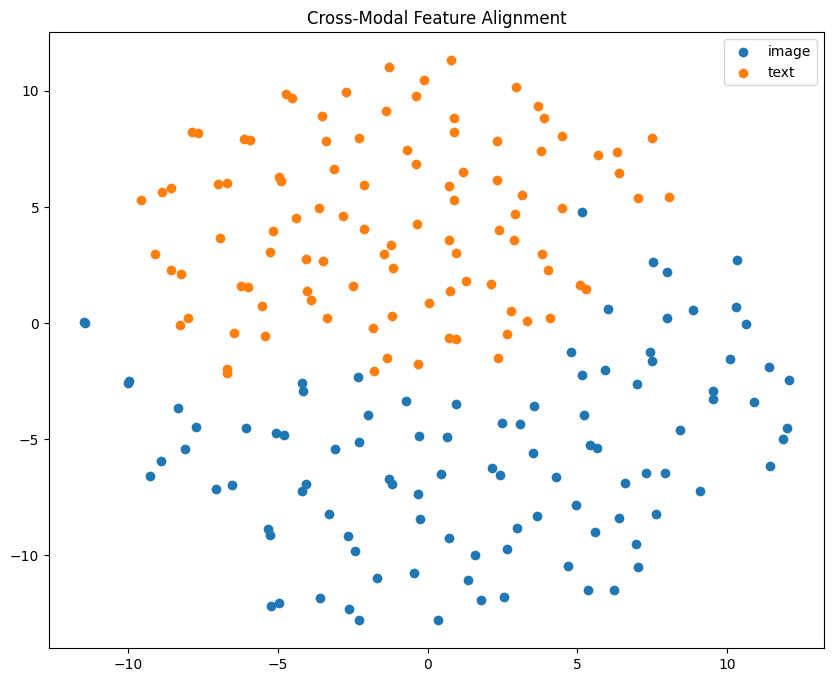

In [6]:
def visualize_alignment(model):
    # 生成测试数据
    num_samples = 100
    image_feat = torch.randn(num_samples, 2048)
    text_feat = torch.randn(num_samples, 768)

    # 获取投影后特征
    with torch.no_grad():
        proj_image = model.projectors['image'](image_feat)
        proj_text = model.projectors['text'](text_feat)

    # 使用t-SNE降维
    combined = torch.cat([proj_image, proj_text], dim=0).numpy()
    labels = ['image']*num_samples + ['text']*num_samples

    tsne = TSNE(n_components=2)
    reduced = tsne.fit_transform(combined)

    # 可视化
    plt.figure(figsize=(10,8))
    for i, label in enumerate(['image', 'text']):
        mask = [l == label for l in labels]
        plt.scatter(reduced[mask,0], reduced[mask,1], label=label)
    plt.title("Cross-Modal Feature Alignment")
    plt.legend()
    plt.show()

# 执行可视化
visualize_alignment(model)

## 6. 多模态对比学习示例
实现跨模态对比损失

In [7]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temp = temperature

    def forward(self, features_a, features_b):
        # 计算相似度矩阵
        sim_matrix = torch.mm(features_a, features_b.T) / self.temp

        # 生成目标标签
        targets = torch.arange(features_a.size(0)).to(features_a.device)

        # 对称损失计算
        loss_a = F.cross_entropy(sim_matrix, targets)
        loss_b = F.cross_entropy(sim_matrix.T, targets)
        return (loss_a + loss_b) / 2

## 7. 端到端训练示例
完整训练流程演示

In [8]:
def training_example():
    # 初始化模型
    model = CrossModalProcessor(
        mod_dims={'image':2048, 'text':768},
        proj_dim=256,
        fusion_mode='mlp'
    )

    # 定义优化器和损失函数
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion = ContrastiveLoss()

    # 模拟训练数据
    batch_size = 32
    train_steps = 100

    for step in range(train_steps):
        # 生成随机数据
        image_feat = torch.randn(batch_size, 2048)
        text_feat = torch.randn(batch_size, 768)

        # 前向传播
        fused_feat = model({'image': image_feat, 'text': text_feat})

        # 拆分模态特征
        image_proj = model.projectors['image'](image_feat)
        text_proj = model.projectors['text'](text_feat)

        # 计算对比损失
        loss = criterion(image_proj, text_proj)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            print(f"Step {step}, Loss: {loss.item():.4f}")

# 执行训练示例
training_example()

Step 0, Loss: 3.5434
Step 10, Loss: 3.7524
Step 20, Loss: 3.8930
Step 30, Loss: 4.0186
Step 40, Loss: 3.7422
Step 50, Loss: 4.1168
Step 60, Loss: 3.8769
Step 70, Loss: 3.9106
Step 80, Loss: 3.6017
Step 90, Loss: 3.7686
